https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

The Convolutional Neural Network (CNN or ConvNet) is a subtype of Neural Networks that is mainly used for applications in image and speech recognition. Its built-in convolutional layer reduces the high dimensionality of images without losing its information. That is why CNNs are especially suited for this use case.

Lorsque vous utilisez une architecture de CNN, vous utilisez deux types de fonctionnalités artisanales : les convolutional layers (les filtres de convolution) et les pooling layers (les filtres de regroupement).
Le but du CNN est de transformer notre image de départ en vecteur qui serait la représentation vectorielle des caractéristiques de notre image.

In [ ]:
!pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.4 MB/s eta 0:13:43tcmalloc: large alloc 1147494400 bytes == 0x392ca000 @  0x7f4e259a5615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████████████████               | 1055.7 MB 1.2 MB/s eta 0:12:24tcmalloc: large alloc 1434370048 bytes == 0x7d920000 @  0x7f4e259a5615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████

In [1]:
import torch
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
from torch.utils.data import DataLoader,random_split
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary

Files already downloaded and verified
Files already downloaded and verified


(-0.5, 165.5, 165.5, -0.5)

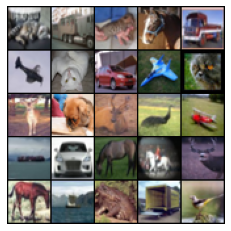

In [2]:
#Initializing normalizing transform for the dataset
normalize_transform = Compose([ToTensor(), Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))])

#Downloading the CIFAR10 dataset into train and test sets
train_dataset = CIFAR10(root="./CIFAR10/train", train=True, transform=normalize_transform, download=True)
test_set = CIFAR10(root="./CIFAR10/test", train=False, transform=normalize_transform, download=True)
	
#Generating data loaders from the corresponding datasets
batch_size = 128
trainset_size = round(len(train_dataset) * 0.8)
validset_size = len(train_dataset) - trainset_size
trainset, validset = random_split(train_dataset, [trainset_size, validset_size])

train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(validset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=False)

#Plotting 25 images from the 1st batch
dataiter = iter(train_dl)
images, labels = dataiter.next()
plt.imshow(np.transpose(make_grid(images[:25], normalize=True, padding=1, nrow=5).numpy(), (1, 2, 0)))
plt.axis('off')

In [3]:
# compute the loss on validation set for early stopping
def validation(model, device, valid_dl, criterion): # device = cpu ou cuda , criterion= Mean squared error MSE for regression, Binary Cross Entropy BCE for binary classification and Cross Entropy for multi classification
  model.eval() # Sets the module in evaluation mode , c'est à dire training = False
  loss_total = 0
  with torch.no_grad(): 
    """every time you do a forward pass with a torch model (and you are not in a torch.no_grad() block), then gradients will accumulate for the weight tensors of the model, 
  so that when you go to do the backward pass, the gradients are already there and just need to be multiplied that's why we use with torch.no_grad"""
    for data in valid_dl:
      inputs = data[0].to(device)
      labels = data[1].to(device)
      outputs = model(inputs.view(inputs.shape[0], -1)) 
      """ Because the input layer of an MLP takes 1D tensors, we need to reshape 2-dimensional MNIST image data into 1-dimensional data. This process is technically called flattening the image. """
      loss = criterion(outputs, labels)
      loss_total += loss.item()
  
  return loss_total / len(valid_dl)

Text(0, 0.5, 'Number of training instances')

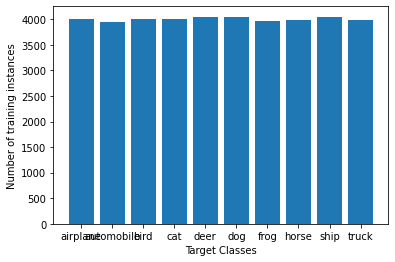

In [4]:

#Iterating over the training dataset and storing the target class for each sample
classes = []
for batch_idx, data in enumerate(train_dl, 0):
    x, y = data 
    classes.extend(y.tolist())
      
#Calculating the unique classes and the respective counts and plotting them
unique, counts = np.unique(classes, return_counts=True)
names = list(test_set.class_to_idx.keys())
plt.bar(names, counts)
plt.xlabel("Target Classes")
plt.ylabel("Number of training instances")

In [9]:
class CNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.model = torch.nn.Sequential(
        #Input = 3 x 32 x 32, Output = 32 x 32 x 32
			  torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
			  torch.nn.ReLU(),
			  #Input = 32 x 32 x 32, Output = 32 x 16 x 16
			  torch.nn.MaxPool2d(kernel_size=2),
				torch.nn.Dropout(0.25),

			  #Input = 32 x 16 x 16, Output = 64 x 16 x 16
			  torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
			  torch.nn.ReLU(),
			  #Input = 64 x 16 x 16, Output = 64 x 8 x 8
			  torch.nn.MaxPool2d(kernel_size=2),
			  torch.nn.Dropout(0.25),
			  #Input = 64 x 8 x 8, Output = 64 x 8 x 8
			  torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
			  torch.nn.ReLU(),
			  #Input = 64 x 8 x 8, Output = 64 x 4 x 4
			  torch.nn.MaxPool2d(kernel_size=2),

			  torch.nn.Flatten(),
			  torch.nn.Linear(64*4*4, 512),
			  torch.nn.ReLU(),
				torch.nn.Dropout(0.25),
			  torch.nn.Linear(512, 10))
  
  def forward(self, x):
    return self.model(x)

In [10]:
def evaluation(model, device, test_dl):
  model.eval()
  total = 0.0; correct = 0.0 
  with torch.no_grad():
    for data in test_dl:
      inputs = data[0].to(device)
      labels = data[1].to(device)
      outputs = model(inputs.view(inputs.shape[0], -1))
      _, predicted = torch.max(outputs.data, 1)      
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = correct/total
  return accuracy



In [11]:
# compute the loss on validation set for early stopping
def validation(model, device, valid_dl, criterion): # device = cpu ou cuda , criterion= Mean squared error MSE for regression, Binary Cross Entropy BCE for binary classification and Cross Entropy for multi classification
  model.eval() # Sets the module in evaluation mode , c'est à dire training = False
  loss_total = 0
  with torch.no_grad(): 
    """every time you do a forward pass with a torch model (and you are not in a torch.no_grad() block), then gradients will accumulate for the weight tensors of the model, 
  so that when you go to do the backward pass, the gradients are already there and just need to be multiplied that's why we use with torch.no_grad"""
    for i, (images, labels) in enumerate(valid_dl):
      images = images.to(device)
      labels = labels.to(device)
      #Calculating the model output and the cross entropy loss
      outputs = model(images)
      """ Because the input layer of an MLP takes 1D tensors, we need to reshape 2-dimensional MNIST image data into 1-dimensional data. This process is technically called flattening the image. """
      loss = criterion(outputs, labels)
      loss_total += loss.item()
  
  return loss_total / len(valid_dl)

In [ ]:
# Training 
def train_model(model, device, epochs, optimizer, criterion, train_dl, valid_dl):
  last_loss = 100; patience = 2; triggertimes = 0  
  """ patience: Number of epochs with no improvement after which training will be stopped
      triggertimes: combine on va attendre aprés les 2 epochs """    
  for epoch in range(1,epochs+1):
    model.train() # Sets the module in traininng mode
    for i, (images, labels) in enumerate(train_dl):
      #Extracting images and target labels for the batch being iterated
      images = images.to(device)
      labels = labels.to(device)
      #Calculating the model output and the cross entropy loss
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Zero the gradients
      optimizer.zero_grad()
      # Forward and backward propagation     
      loss.backward()
      optimizer.step() # mettre à jour les paramètres
      # Show progress
      if batch_idx % 100 == 0 or batch_idx == len(train_dl):
        print('[{}/{}, {}/{}] loss: {:.8}'.format(epoch, epochs, batch_idx, len(train_dl), loss.item()))
    


    # Early stopping
    current_loss = validation(model, device, valid_dl, criterion)
    if current_loss > last_loss:
      triggertimes += 1 
      print('trigger times', triggertimes)       
    if triggertimes >= patience:
      print('Perform Early stopping!')
      return model
    else:
      trigger_times = 0 
      print('trigger times', triggertimes)          
    last_loss = current_loss
    
  return model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)
summary(model,(3,32,32))
#Defining the model hyper parameters
epochs = 50
learning_rate = 0.001
weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
model = train_model(model, device, epochs, optimizer, criterion, train_dl, valid_dl)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
           Dropout-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
              ReLU-6           [-1, 64, 16, 16]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
           Dropout-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
             ReLU-10             [-1, 64, 8, 8]               0
        MaxPool2d-11             [-1, 64, 4, 4]               0
          Flatten-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
             ReLU-14                  [

In [ ]:
# evaulate model on test dataset
test_acc=0
model.eval()

with torch.no_grad():
	#Iterating over the test dataset in batches
	for i, (images, labels) in enumerate(test_dl):
		
		images = images.to(device)
		y_true = labels.to(device)
		
		#Calculating outputs for the batch being iterated
		outputs = model(images)
		
		#Calculated prediction labels from models
		_, y_pred = torch.max(outputs.data, 1)
		
		#Comparing predicted and true labels
		test_acc += (y_pred == y_true).sum().item()
	
	print(f"Test set accuracy = {100 * test_acc / len(test_set)} %")


(-0.5, 165.5, 33.5, -0.5)

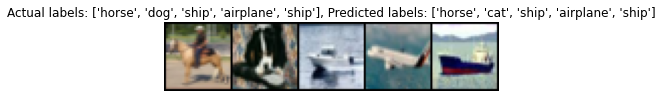

In [ ]:
#Generating predictions for 'num_images' amount of images from the last batch of test set
num_images = 5
y_true_name = [names[y_true[idx]] for idx in range(num_images)]
y_pred_name = [names[y_pred[idx]] for idx in range(num_images)]

#Generating the title for the plot
title = f"Actual labels: {y_true_name}, Predicted labels: {y_pred_name}"

#Finally plotting the images with their actual and predicted labels in the title
plt.imshow(np.transpose(make_grid(images[:num_images].cpu(), normalize=True, padding=1).numpy(), (1, 2, 0)))
plt.title(title)
plt.axis("off")